In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from tqdm import tqdm
import seaborn as sns

In [2]:
npz_files = sorted(glob.glob("*.npz"), key=lambda x: int(x.split(".")[0]))
iterations = [int(file.split(".")[0]) for file in npz_files]

In [4]:
distilled_data = {}

for file in tqdm(npz_files):
    iteration = int(file.split(".")[0])
    data = np.load(file)
    distilled_data[iteration] = {key: data[key] for key in data.keys()}

100%|██████████| 25/25 [00:00<00:00, 64.28it/s]


In [5]:
def plot_evolution(distilled_data, iterations_to_show, num_samples=5):
    fig, axes = plt.subplots(len(iterations_to_show), num_samples, figsize=(15, len(iterations_to_show) * 3))

    for i, iteration in enumerate(iterations_to_show):
        images = distilled_data[iteration]['images']

        for j in range(num_samples):
            if j < len(images):
                img = images[j]
                if img.shape[0] == 1 or img.shape[0] == 3:
                    img = img.transpose(1, 2, 0)
                if img.shape[2] == 1:
                    axes[i, j].imshow(img.squeeze(), cmap='gray')
                else:
                    axes[i, j].imshow(img)
                axes[i, j].axis('off')
                axes[i, j].set_title(f"Iter {iteration} - Sample {j+1}")
    
    plt.tight_layout()
    plt.savefig("evolution_plot.png", dpi=300)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5844551..1.4526277].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.1974173..3.8138845].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6312133..1.6907359].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2758732..1.047031].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.6039512..3.5304976].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.86824274..1.2040691].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.620754

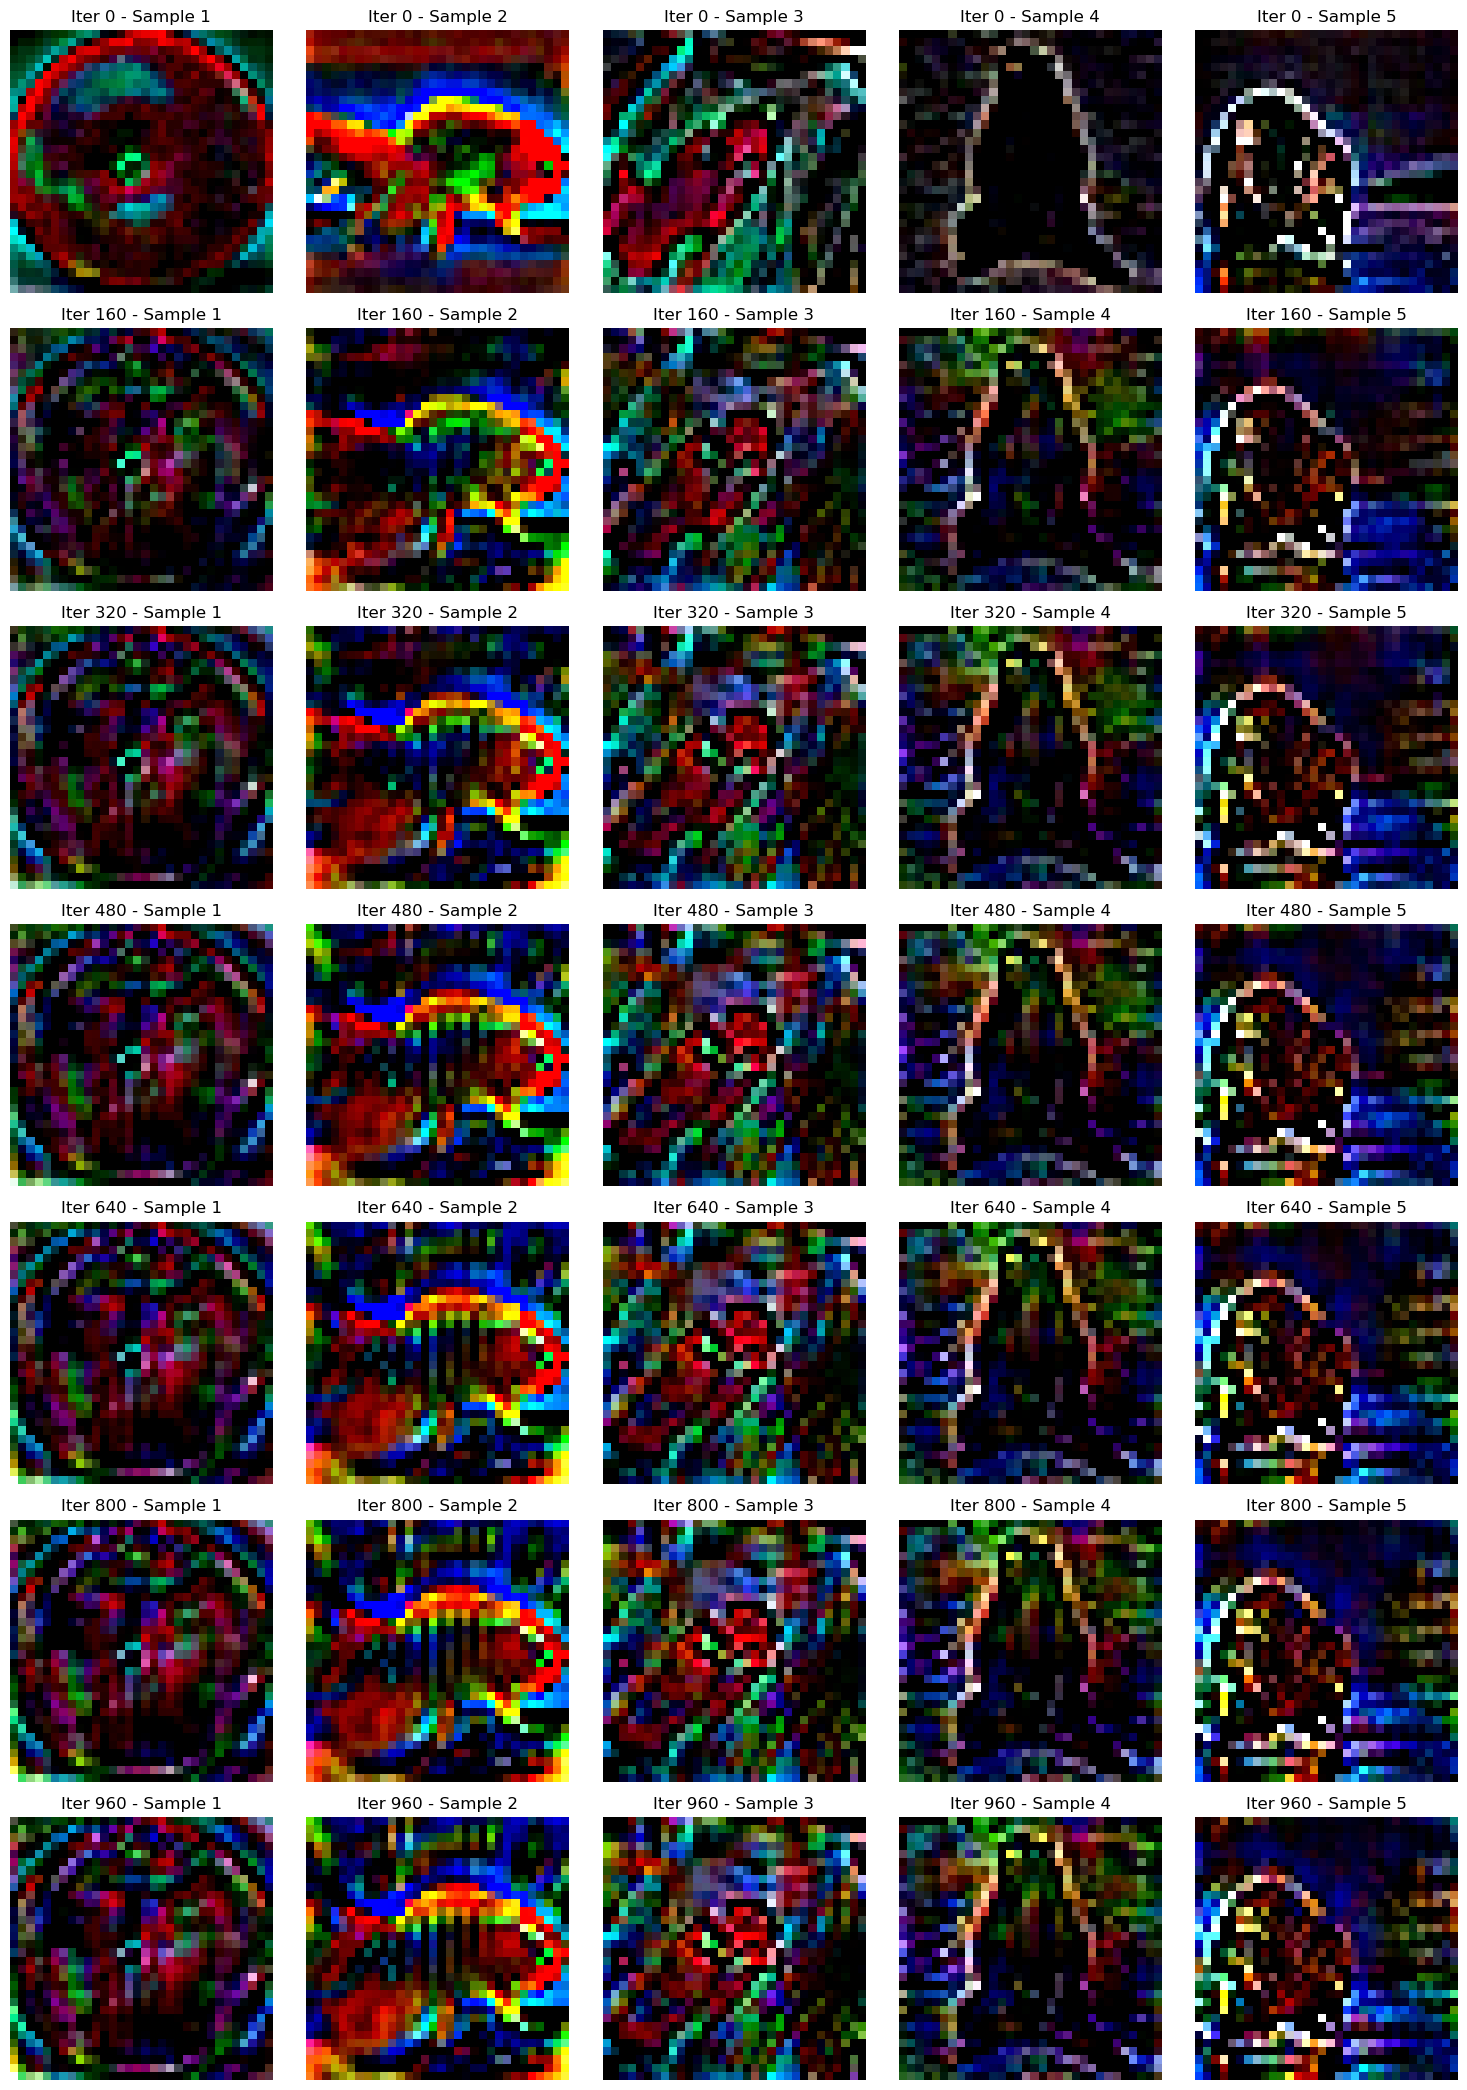

In [6]:
key_iterations = [0, 160, 320, 480, 640, 800, 960]
plot_evolution(distilled_data, key_iterations)

In [24]:
from sklearn.manifold import TSNE
import umap.umap_ as umap

def visualize_feature_space(distilled_data, iterations_to_show, method='tsne'):
    plt.figure(figsize=(15, 10))
    
    for i, iter_num in enumerate(iterations_to_show):
        # Assuming 'images' is the key for distilled images in your .npz files
        images = distilled_data[iter_num]['images']
        
        # Flatten images to feature vectors
        flat_images = images.reshape(images.shape[0], -1)
        
        # Dimensionality reduction
        if method == 'tsne':
            embedded = TSNE(n_components=2, random_state=42).fit_transform(flat_images)
        elif method == 'umap':  # umap
            reducer = umap.UMAP()
            embedded = reducer.fit_transform(flat_images)
        
        # Plot with different color for each iteration
        plt.scatter(embedded[:, 0], embedded[:, 1], label=f'Iter {iter_num}', alpha=0.7)
    
    plt.title(f'{method.upper()} Visualization of Distilled Images')
    plt.legend()
    plt.savefig(f'{method}_visualization.png', dpi=300)
    plt.show()

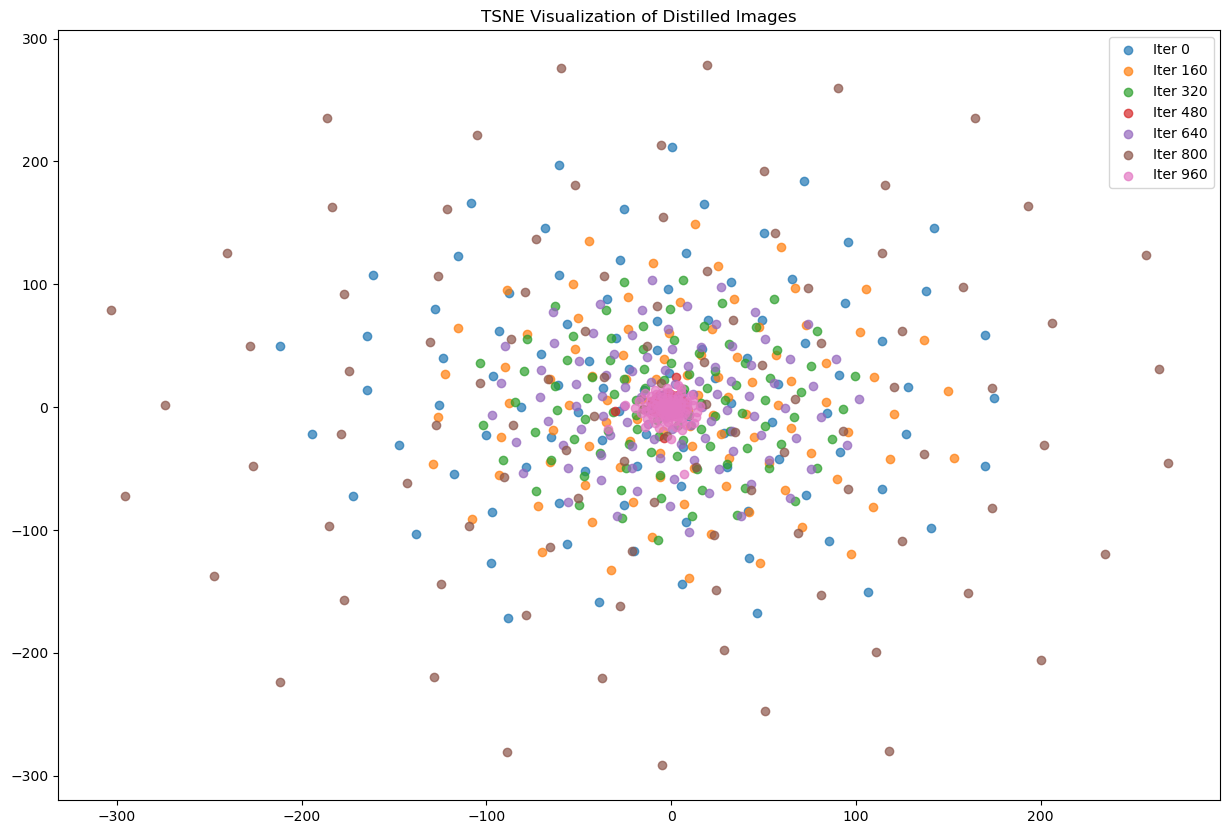

In [19]:
# Visualize using t-SNE
key_iterations = [0, 160, 320, 480, 640, 800, 960]
visualize_feature_space(distilled_data, key_iterations, method='tsne')

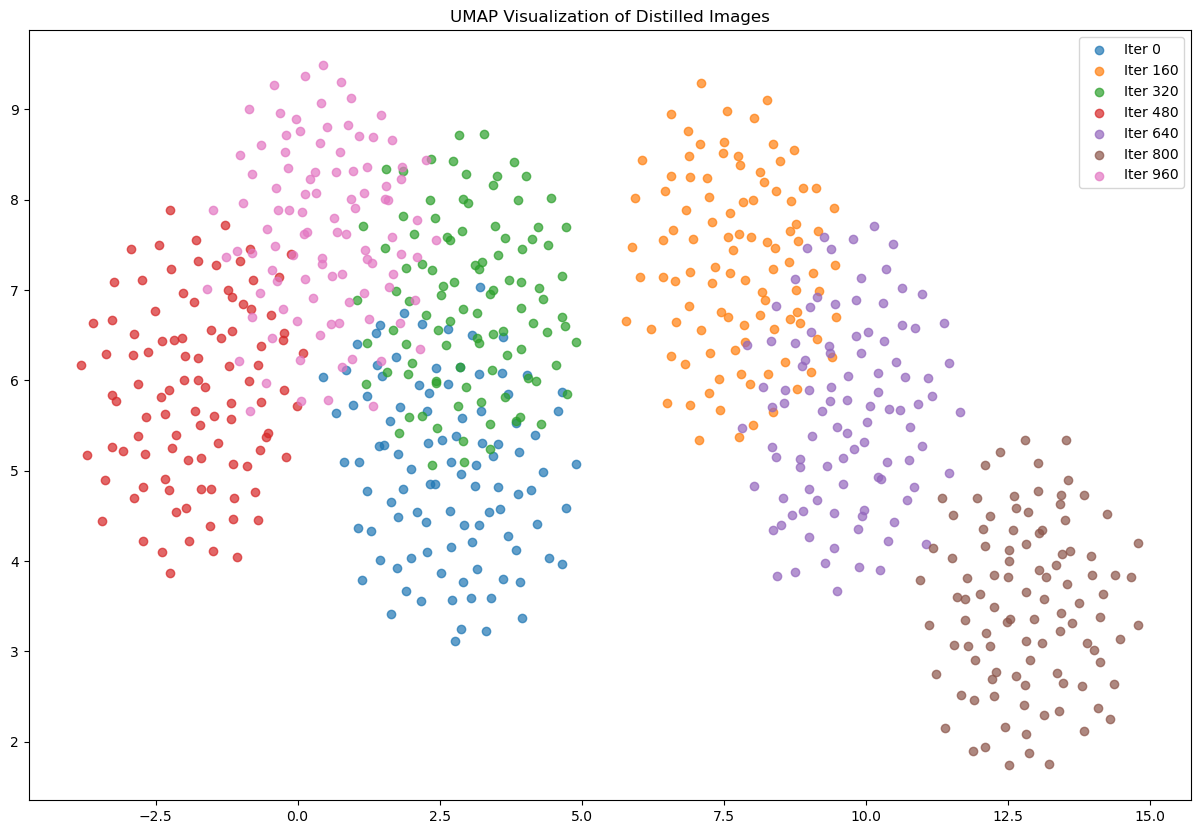

In [25]:
visualize_feature_space(distilled_data, key_iterations, method='umap')

In [26]:
import matplotlib.animation as animation

def create_distillation_animation(distilled_data, sample_idx=0):
    iterations = sorted(list(distilled_data.keys()))
    
    fig = plt.figure(figsize=(6, 6))
    
    images = []
    for iter_num in iterations:
        img = distilled_data[iter_num]['images'][sample_idx]
        if img.shape[0] == 1 or img.shape[0] == 3:  # Channel-first format
            img = np.transpose(img, (1, 2, 0))
        if img.shape[2] == 1:  # Grayscale
            im = plt.imshow(img.squeeze(), cmap='gray', animated=True)
        else:  # RGB
            im = plt.imshow(img, animated=True)
        plt.title(f'Iteration: {iter_num}')
        plt.axis('off')
        images.append([im])
    
    ani = animation.ArtistAnimation(fig, images, interval=200, blit=True)
    ani.save('distillation_progress.gif', writer='pillow', fps=5)
    plt.close()

# Create animation for the first sample
create_distillation_animation(distilled_data)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5844551..1.4526277].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9878161..1.2542475].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0438056..1.2779124].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.95455074..1.2078071].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.86824274..1.2040691].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8748399..1.1402541].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8564

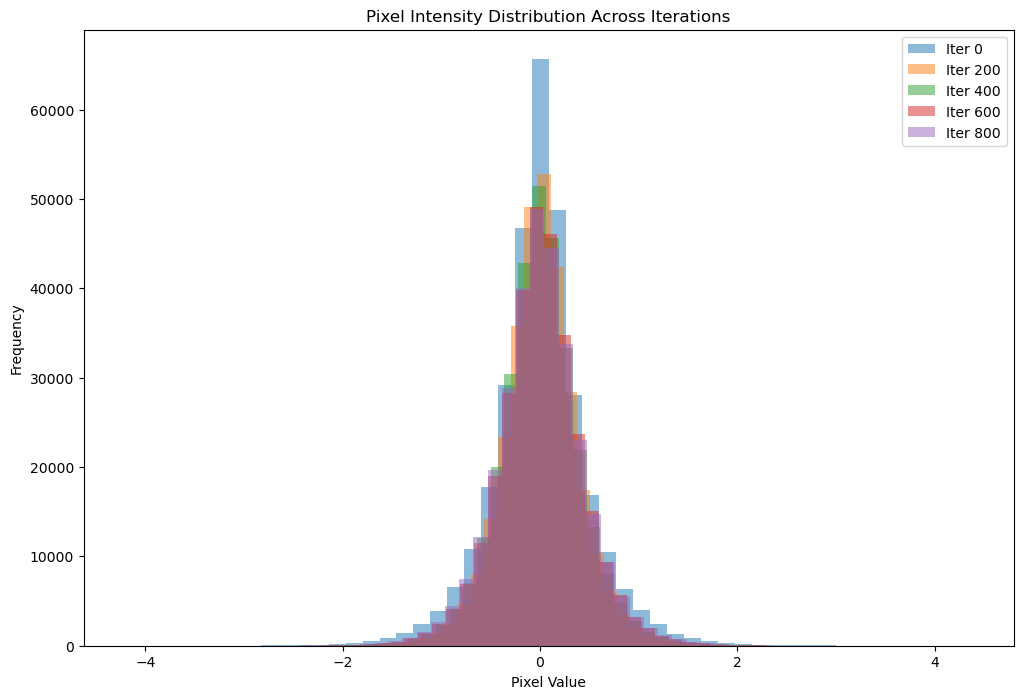

In [27]:
def track_pixel_distributions(distilled_data):
    iterations = sorted(list(distilled_data.keys()))
    sampled_iterations = iterations[::max(1, len(iterations)//5)]  # Sample ~5 iterations
    
    plt.figure(figsize=(12, 8))
    
    for iter_num in sampled_iterations:
        imgs = distilled_data[iter_num]['images']
        pixel_values = imgs.flatten()
        
        plt.hist(pixel_values, bins=50, alpha=0.5, label=f'Iter {iter_num}')
    
    plt.title('Pixel Intensity Distribution Across Iterations')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.savefig('pixel_distribution.png', dpi=300)
    plt.show()

track_pixel_distributions(distilled_data)

#### Now, applying some transforms:

In [28]:
def normalize_for_visualization(images):
    """Normalize images to [0,1] range for proper visualization"""
    normalized = []
    for img in images:
        # Handle per image
        img_min = img.min()
        img_max = img.max()
        
        # Avoid division by zero
        if img_max > img_min:
            img_normalized = (img - img_min) / (img_max - img_min)
        else:
            img_normalized = img - img_min  # Just shift if all values are the same
            
        normalized.append(img_normalized)
    
    return np.array(normalized)

In [29]:
def preprocess_distilled_images(images, clip_percentile=1):
    """
    Preprocess distilled images by:
    1. Clipping extreme outliers using percentiles
    2. Scaling to [0,1] range
    """
    processed = []
    
    for img in images:
        # Find percentile values to avoid extreme outliers
        low = np.percentile(img, clip_percentile)
        high = np.percentile(img, 100 - clip_percentile)
        
        # Clip the image
        img_clipped = np.clip(img, low, high)
        
        # Scale to [0,1]
        img_scaled = (img_clipped - low) / (high - low) if high > low else img_clipped - low
        
        processed.append(img_scaled)
    
    return np.array(processed)

In [30]:
from skimage import exposure

def enhance_distilled_images(images):
    """
    Enhance distilled images using histogram equalization
    """
    enhanced = []
    
    for img in images:
        # First normalize to [0,1]
        img_min, img_max = img.min(), img.max()
        if img_max > img_min:
            img_norm = (img - img_min) / (img_max - img_min)
        else:
            img_norm = img - img_min
        
        # Apply histogram equalization for better contrast
        if img.shape[0] == 3:  # RGB image with channels first
            img_eq = np.zeros_like(img_norm)
            for c in range(3):
                img_eq[c] = exposure.equalize_hist(img_norm[c])
        elif img.shape[0] == 1:  # Grayscale with channel first
            img_eq = exposure.equalize_hist(img_norm[0])[np.newaxis, ...]
        else:  # Assume channels last
            img_eq = np.zeros_like(img_norm)
            for c in range(img.shape[-1]):
                img_eq[..., c] = exposure.equalize_hist(img_norm[..., c])
                
        enhanced.append(img_eq)
    
    return np.array(enhanced)

c:\Users\ASUS\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
c:\Users\ASUS\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
c:\Users\ASUS\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


In [31]:
def standardize_images(images):
    """
    Standardize images (zero mean, unit variance) 
    then rescale to [0,1] for visualization
    """
    standardized = []
    
    for img in images:
        # Standardize
        mean = np.mean(img)
        std = np.std(img)
        
        if std > 0:
            img_std = (img - mean) / std
        else:
            img_std = img - mean
        
        # Rescale to [0,1] for visualization
        img_min, img_max = img_std.min(), img_std.max()
        if img_max > img_min:
            img_norm = (img_std - img_min) / (img_max - img_min)
        else:
            img_norm = img_std - img_min
            
        standardized.append(img_norm)
    
    return np.array(standardized)

In [32]:
def robust_scale_images(images, quantile_range=(1, 99)):
    """
    Apply robust scaling using quantiles to handle outliers better
    """
    scaled = []
    
    for img in images:
        q_min, q_max = np.percentile(img, quantile_range)
        
        # Avoid division by zero
        if q_max > q_min:
            img_scaled = (img - q_min) / (q_max - q_min)
        else:
            img_scaled = img - q_min
            
        # Clip any remaining outliers
        img_scaled = np.clip(img_scaled, 0, 1)
        
        scaled.append(img_scaled)
    
    return np.array(scaled)

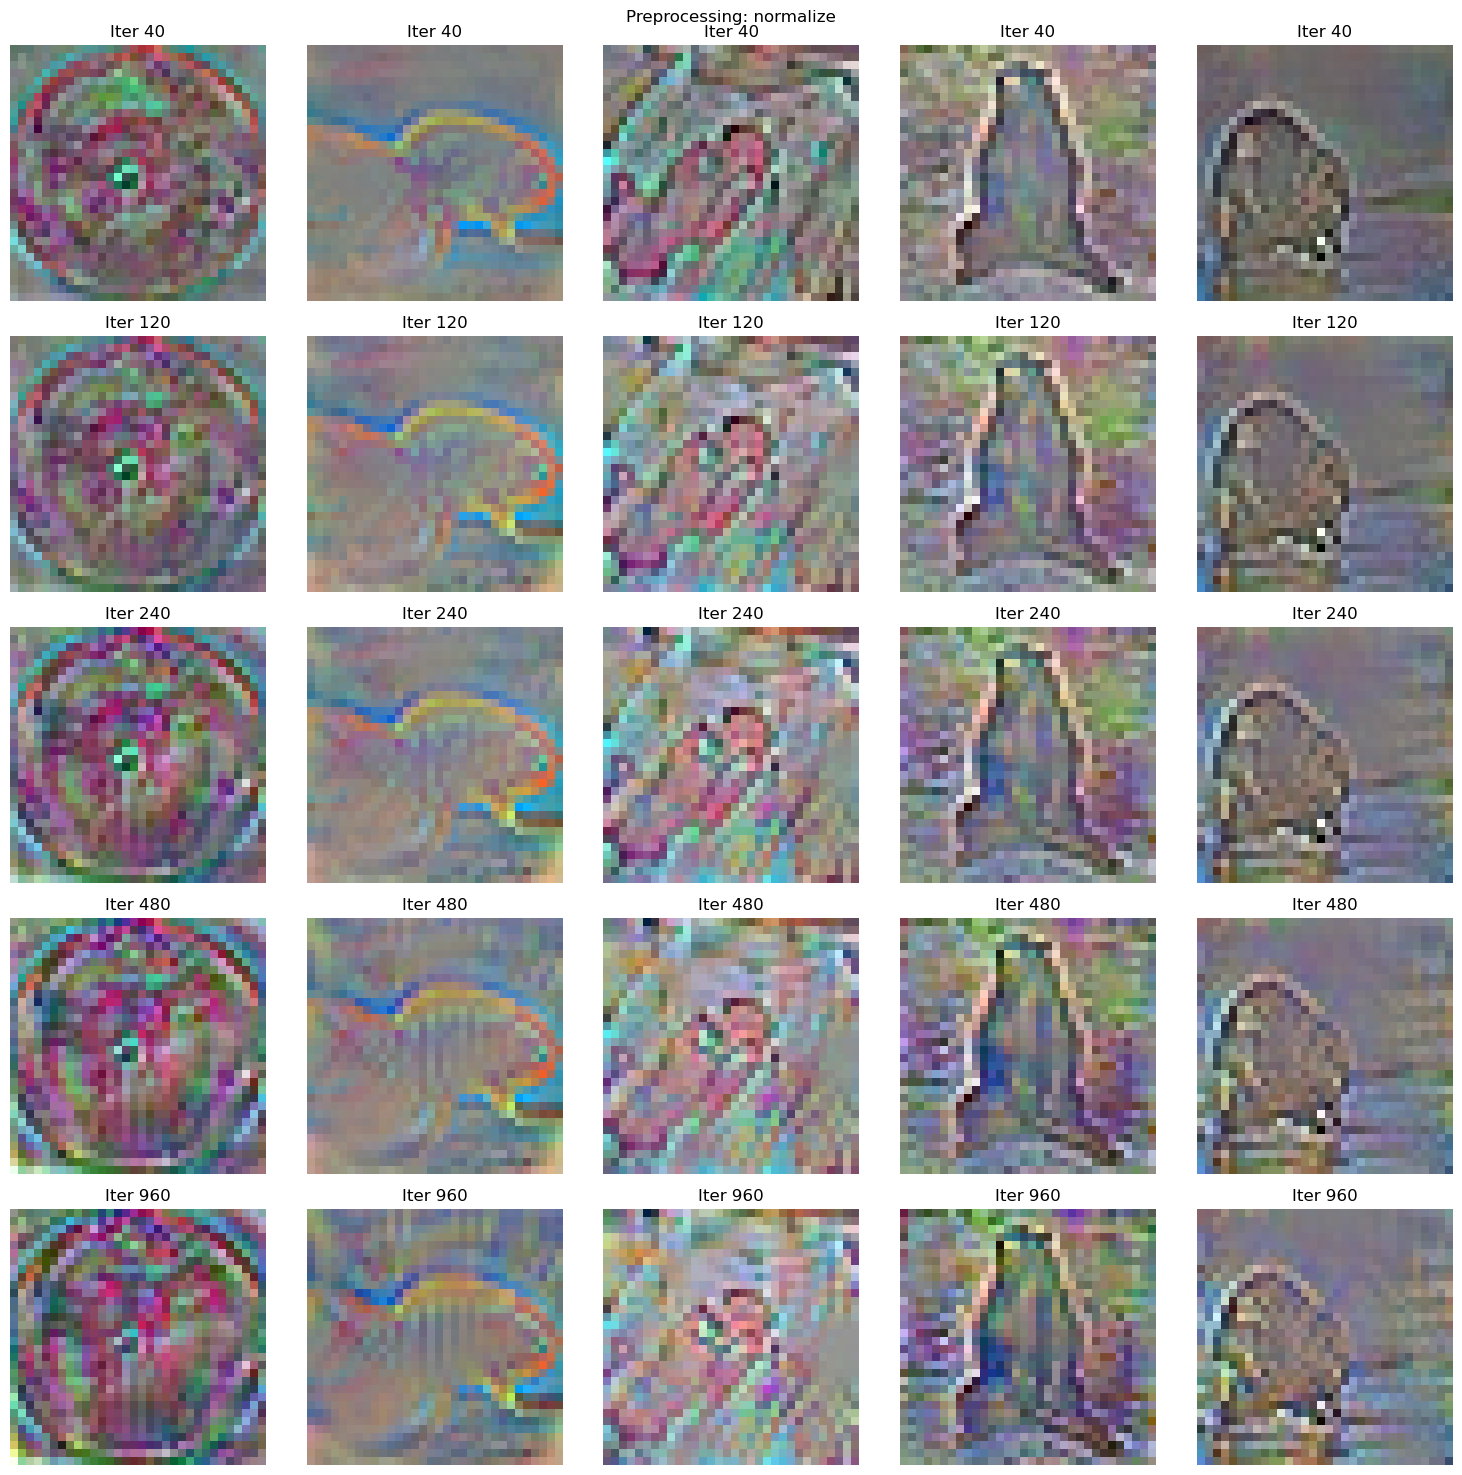

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].


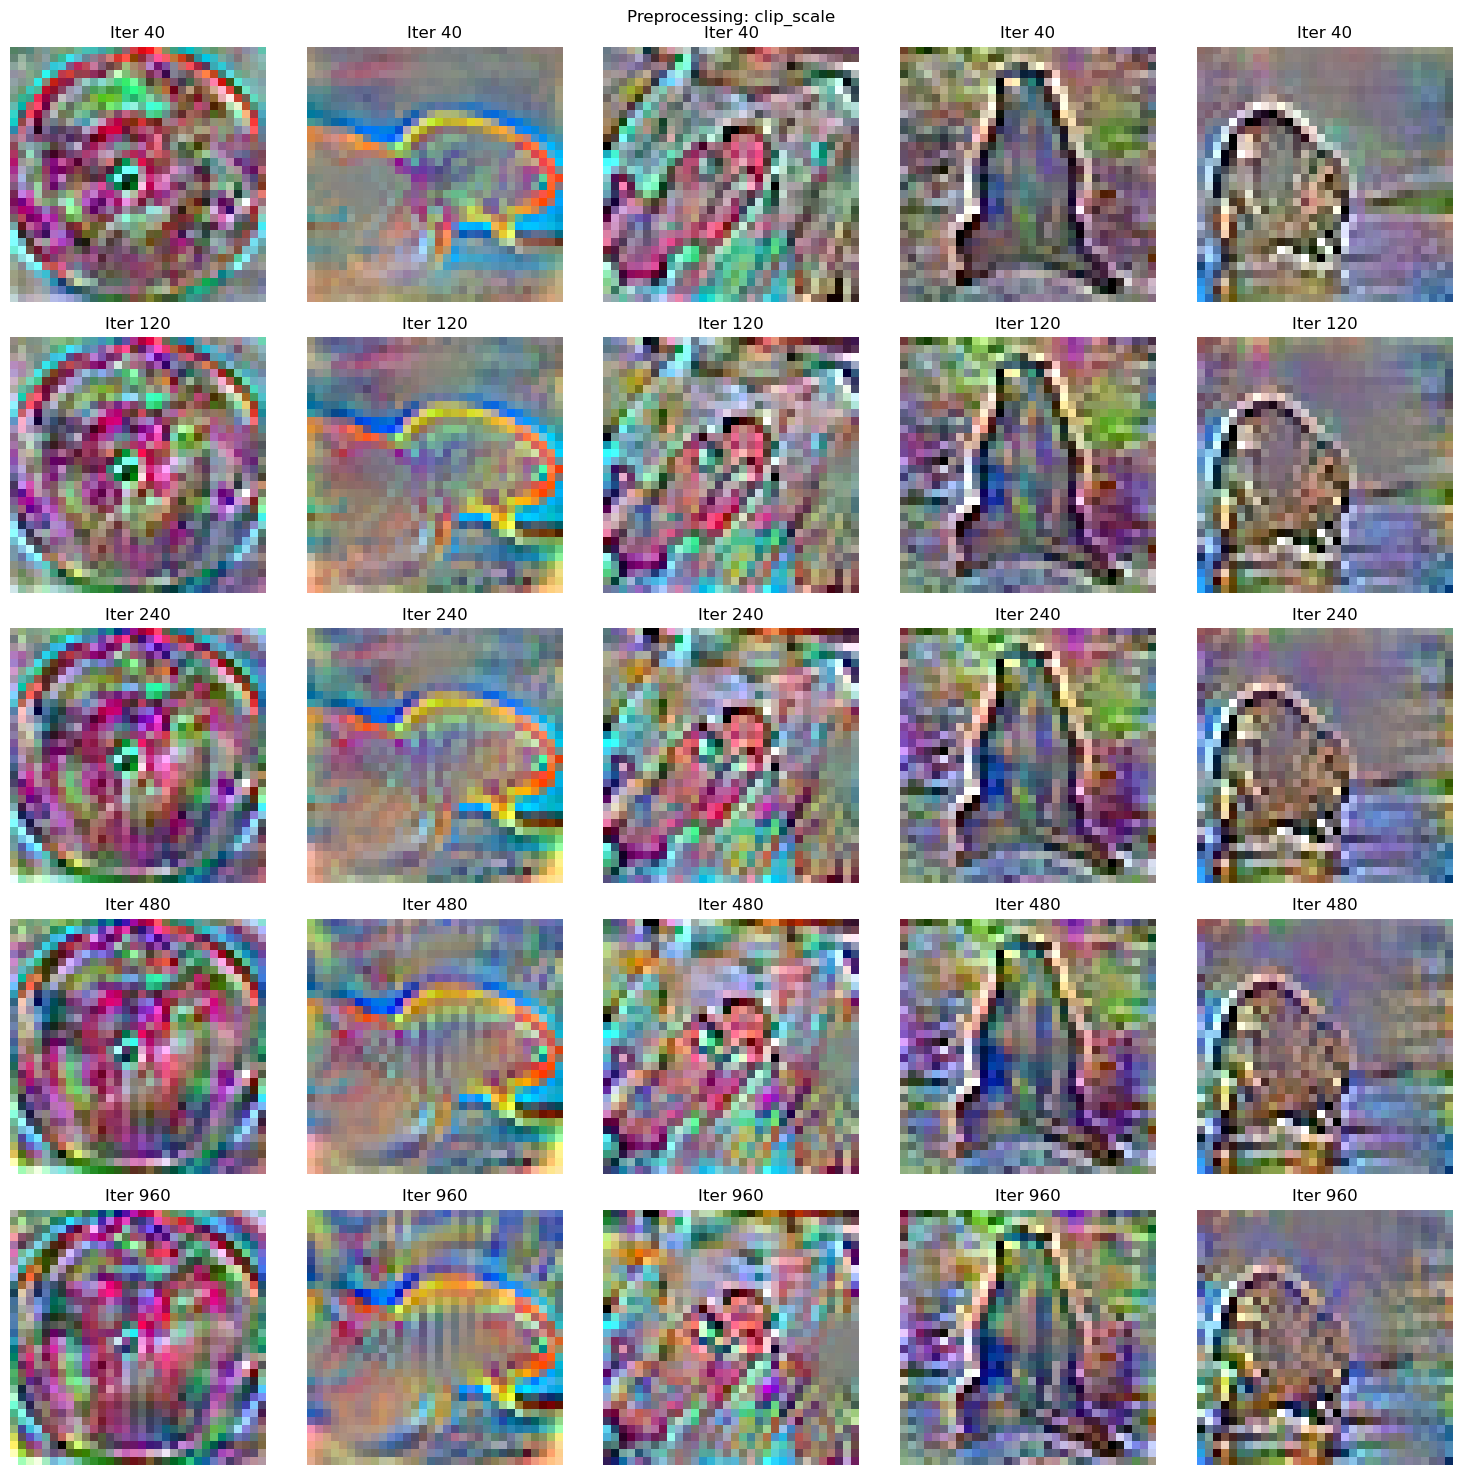

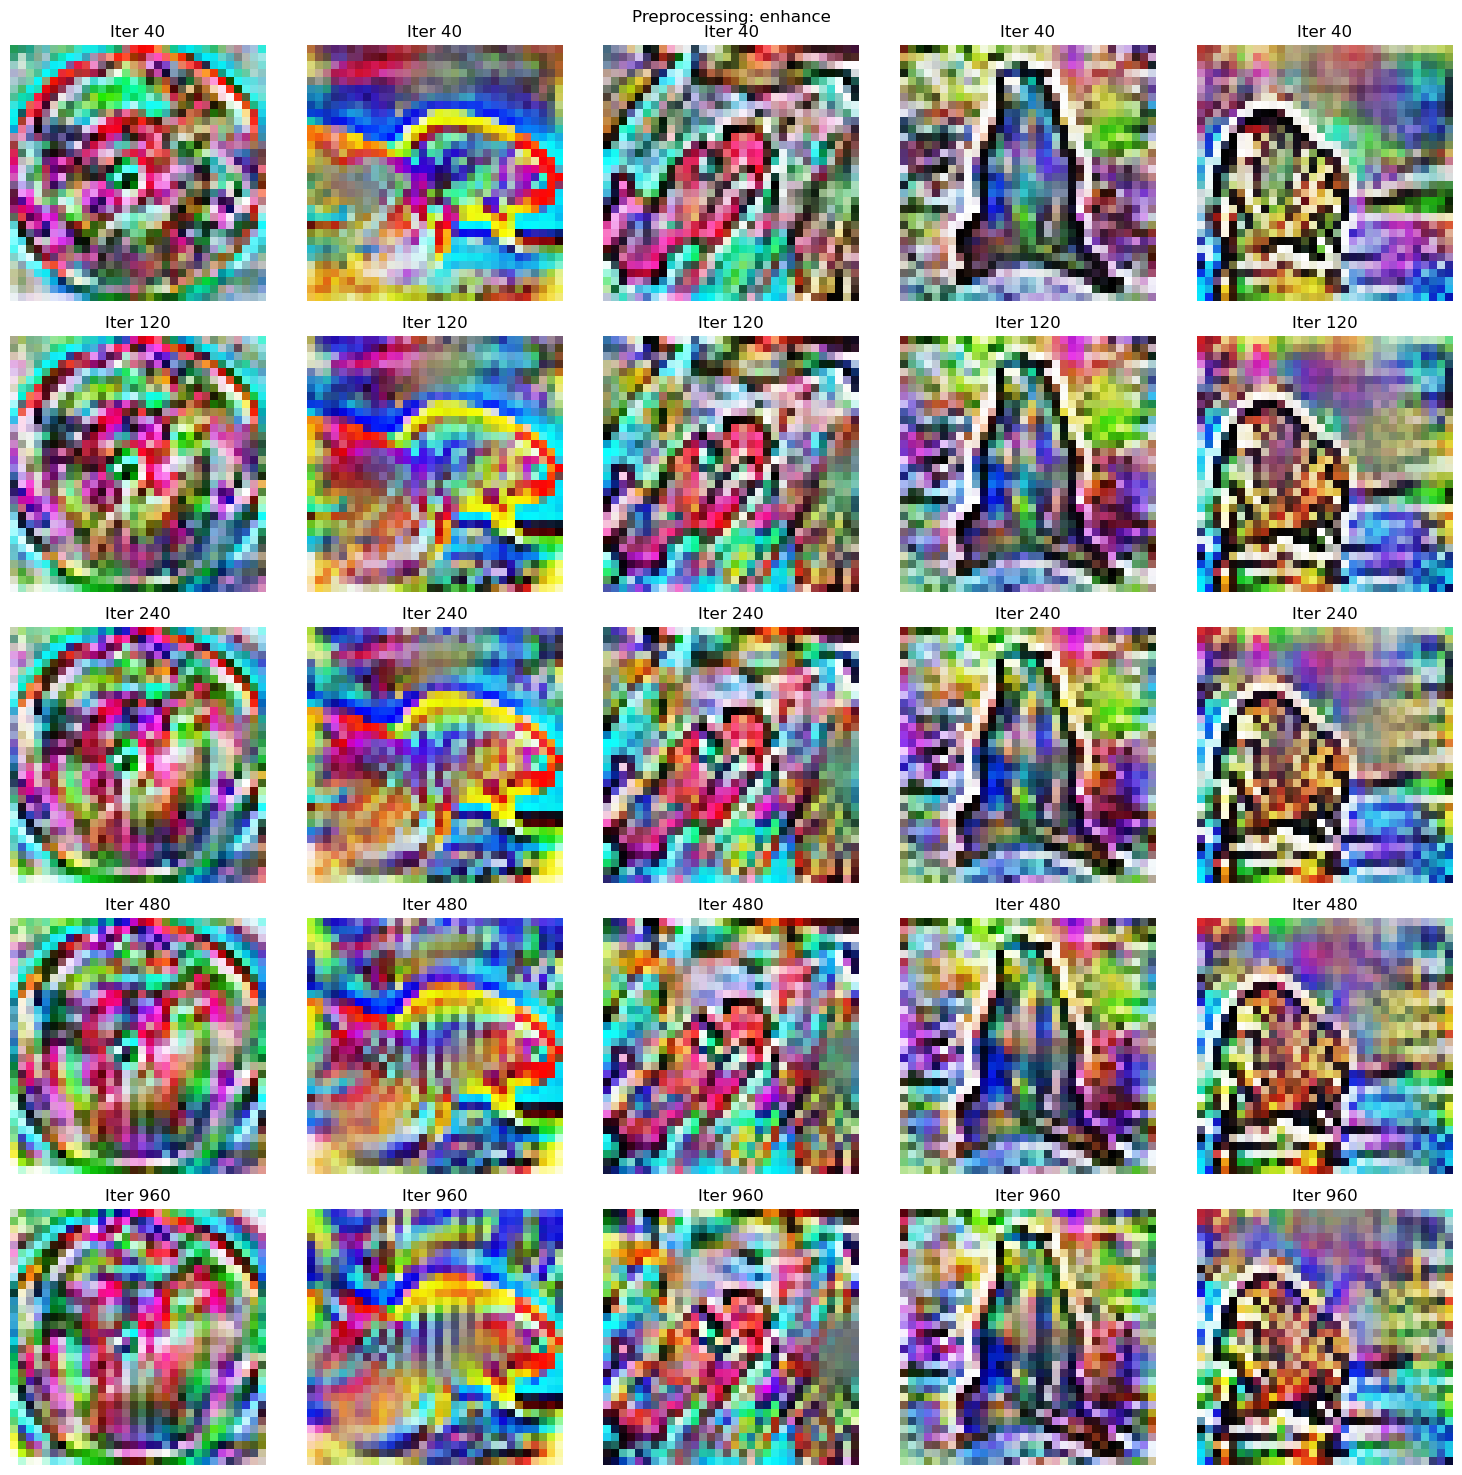

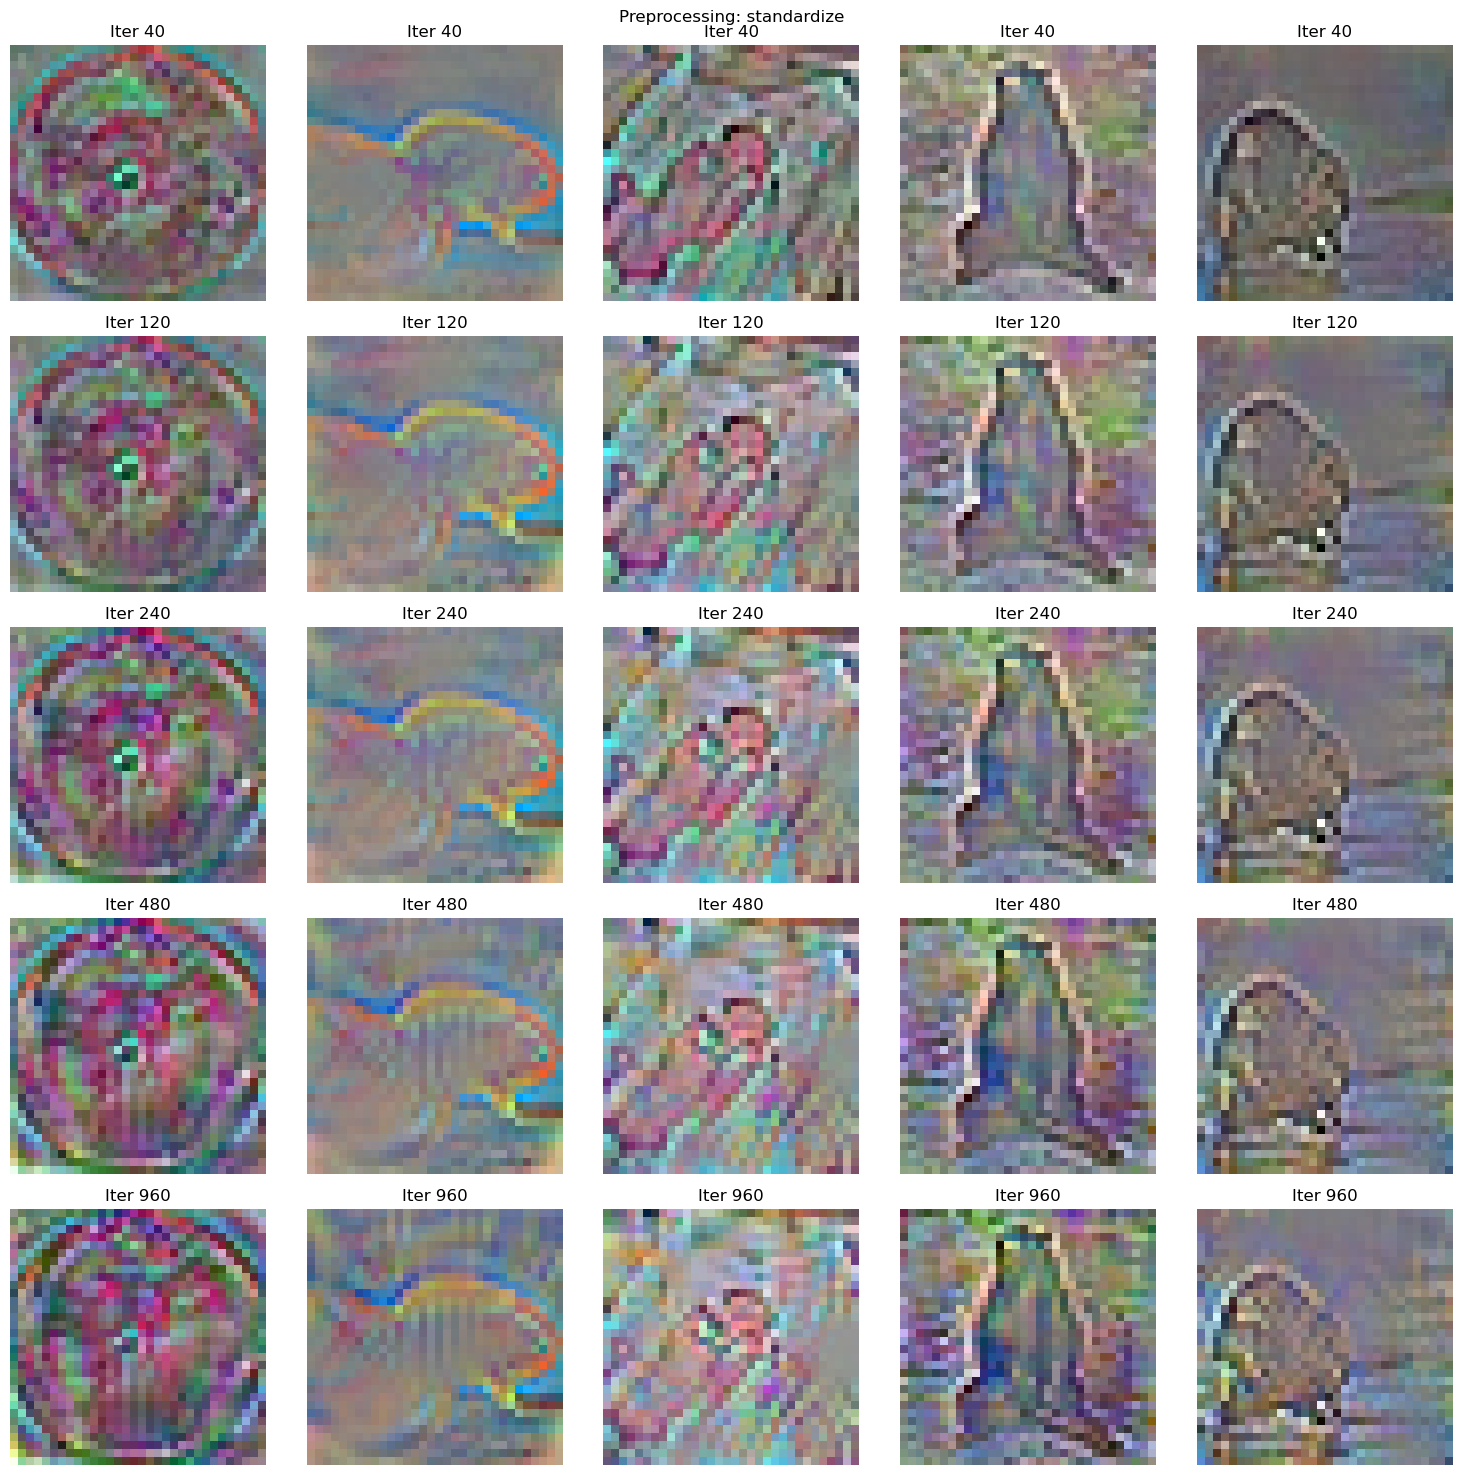

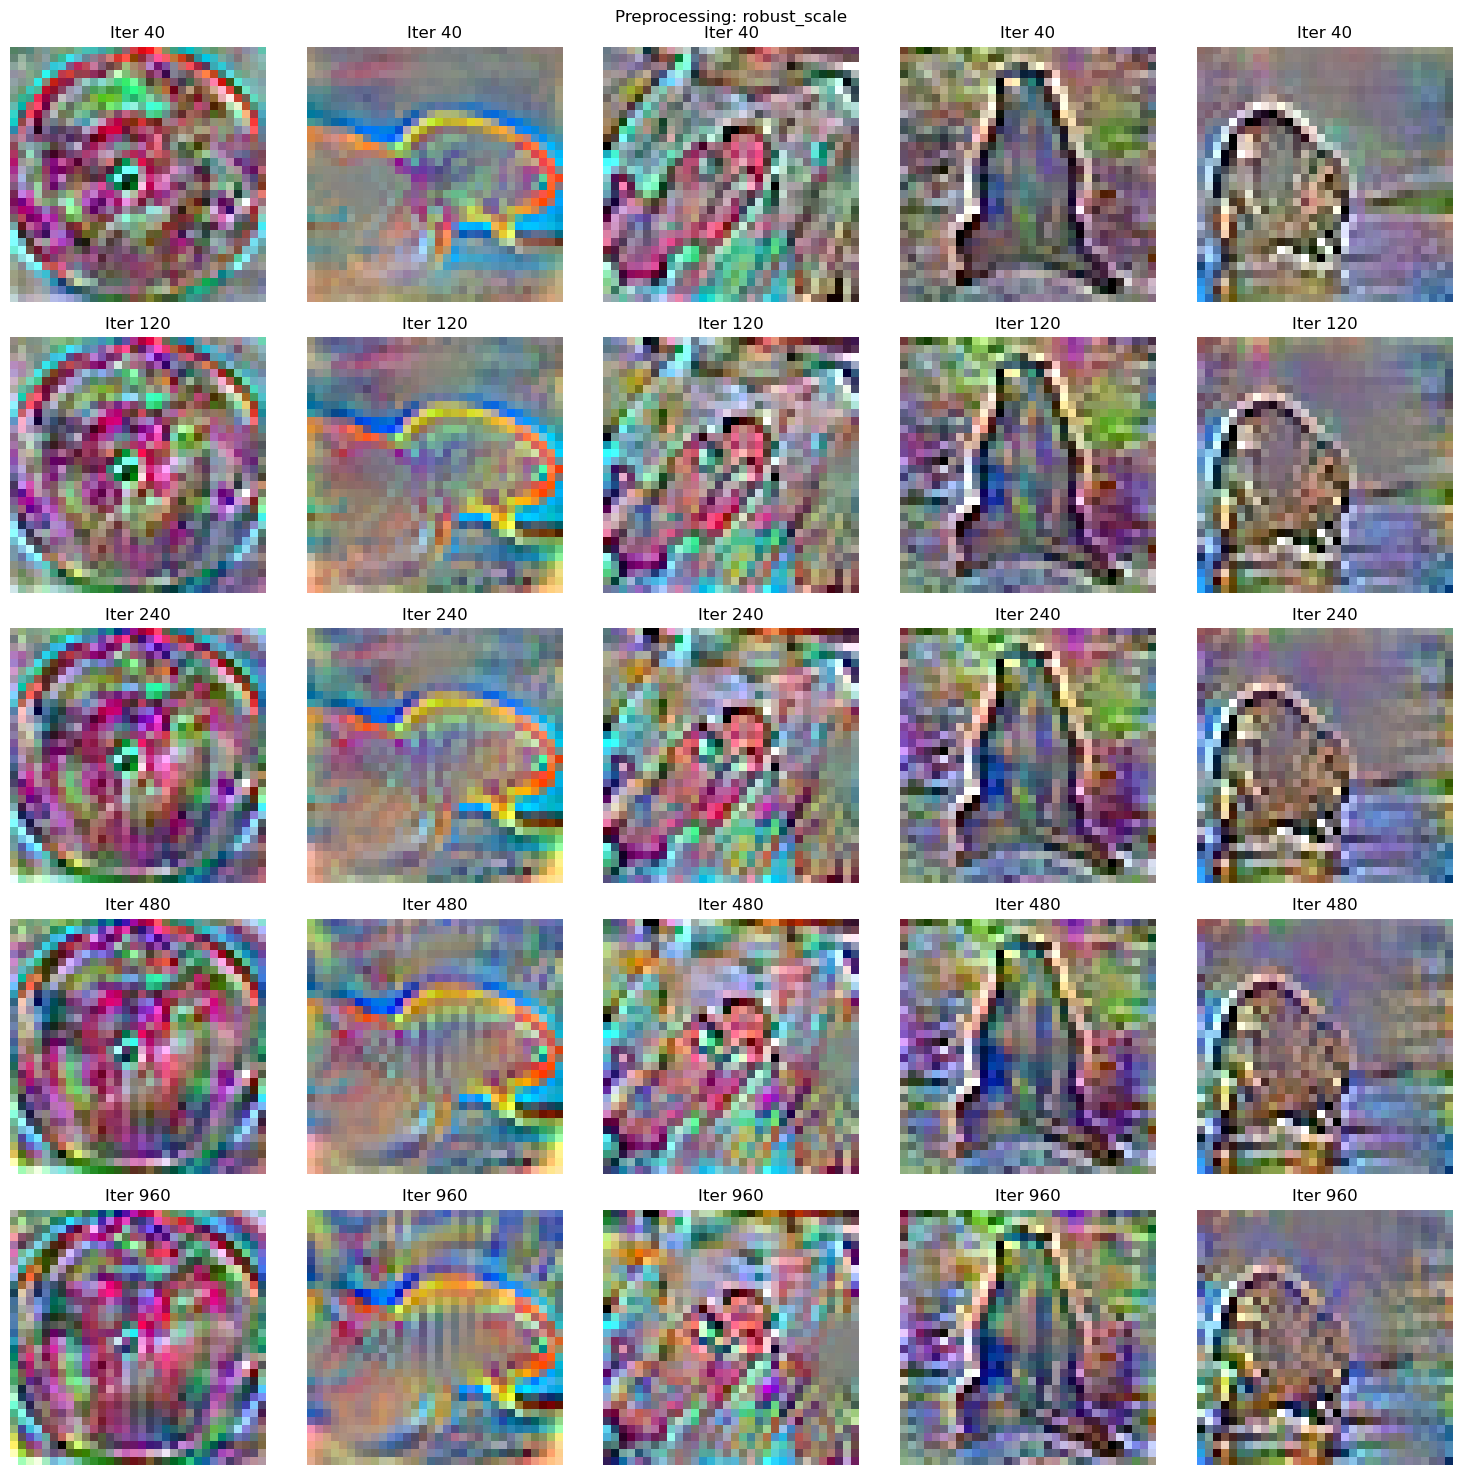

In [33]:
def visualize_distilled_images(distilled_data, iterations_to_show, 
                               preprocess_method='robust_scale', 
                               num_samples=5):
    """
    Visualize distilled images with different preprocessing options
    
    preprocess_method: one of ['normalize', 'clip_scale', 'enhance', 
                              'standardize', 'robust_scale']
    """
    fig, axes = plt.subplots(len(iterations_to_show), num_samples, 
                            figsize=(15, 3*len(iterations_to_show)))
    
    for i, iter_num in enumerate(iterations_to_show):
        # Get images for this iteration
        images = distilled_data[iter_num]['images']
        
        # Apply selected preprocessing
        if preprocess_method == 'normalize':
            images = normalize_for_visualization(images)
        elif preprocess_method == 'clip_scale':
            images = preprocess_distilled_images(images)
        elif preprocess_method == 'enhance':
            images = enhance_distilled_images(images)
        elif preprocess_method == 'standardize':
            images = standardize_images(images)
        elif preprocess_method == 'robust_scale':
            images = robust_scale_images(images)
        
        # Display images
        for j in range(num_samples):
            if j < len(images):
                img = images[j]
                if img.shape[0] == 1 or img.shape[0] == 3:  # Channel-first format
                    img = np.transpose(img, (1, 2, 0))
                if img.shape[2] == 1:  # Grayscale
                    axes[i, j].imshow(img.squeeze(), cmap='gray')
                else:  # RGB
                    axes[i, j].imshow(img)
                axes[i, j].set_title(f"Iter {iter_num}")
                axes[i, j].axis('off')
    
    plt.suptitle(f'Preprocessing: {preprocess_method}')
    plt.tight_layout()
    plt.savefig(f'distilled_images_{preprocess_method}.png', dpi=300)
    plt.show()

# Try different preprocessing methods
key_iterations = [40, 120, 240, 480, 960]
for method in ['normalize', 'clip_scale', 'enhance', 'standardize', 'robust_scale']:
    visualize_distilled_images(distilled_data, key_iterations, preprocess_method=method)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.6487522..1.935374].


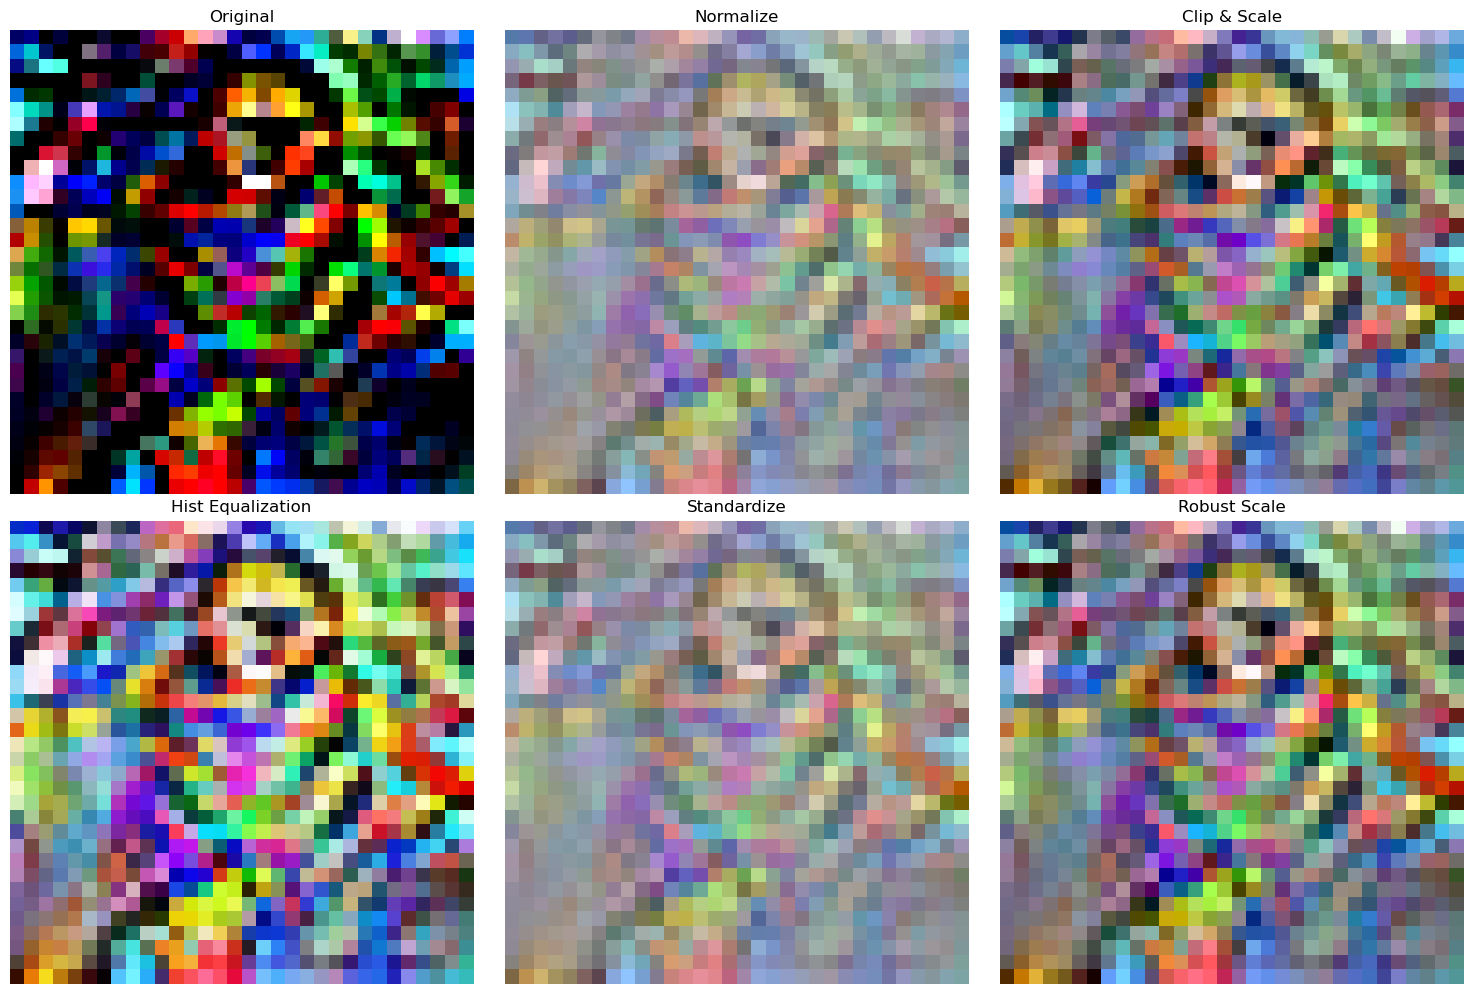

In [37]:
def compare_preprocessing_methods(distilled_data, iteration=960, sample_idx=0):
    """Compare different preprocessing methods on a single image"""
    
    methods = {
        'Original': lambda x: x,
        'Normalize': normalize_for_visualization,
        'Clip & Scale': preprocess_distilled_images,
        'Hist Equalization': enhance_distilled_images,
        'Standardize': standardize_images,
        'Robust Scale': robust_scale_images
    }
    
    # Get a single image
    img = distilled_data[iteration]['images'][sample_idx:sample_idx+1]
    
    # Create figure
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    # Apply and display each method
    for i, (name, method) in enumerate(methods.items()):
        processed = method(img)[0]
        
        if processed.shape[0] == 1 or processed.shape[0] == 3:  # Channel-first
            processed = np.transpose(processed, (1, 2, 0))
            
        if processed.shape[2] == 1:  # Grayscale
            axes[i].imshow(processed.squeeze(), cmap='gray')
        else:  # RGB
            axes[i].imshow(processed)
            
        axes[i].set_title(name)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig('preprocessing_comparison.png', dpi=300)
    plt.show()

# Compare methods on an image from the final iteration
compare_preprocessing_methods(distilled_data, iteration=960, sample_idx=35)